In [1]:
library(CellChat)
library(patchwork)
options(stringsAsFactors = FALSE)
library(Seurat)
#library(SeuratData)
#library(SeuratDisk)
library(reticulate)
use_condaenv("deep")

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject



In [2]:
getwd()

[1] "/mnt/data/jingtao2/scpatients/ipsc"

In [3]:
ad <- import("anndata", convert = FALSE)
# LymphNode , Normal, Tumor, Tumor-2
adata <- ad$read_h5ad('semisdata.h5ad')#("gt50k.h5ad")#ad$read_h5ad("gtdata.h5ad")

In [4]:
gtx = as.matrix(adata$X)

In [5]:
genes = reticulate::py_to_r(adata$var$index)

In [6]:
genes = c()
for (i in 1:length(adata$var$index)){
    gene = as.character(adata$var$index[i-1])
    genes = c(genes,gene)
}

In [7]:
colnames(gtx) = genes

In [8]:
totalcid = c()

for (i in 1:length(adata$obs$index)){
    cid = as.character(adata$obs$index[i-1])
    totalcid = c(totalcid,cid)
}

In [9]:
adata

AnnData object with n_obs × n_vars = 73101 × 6013
    obs: 'sample_ids', 'celltypes', 'repmask'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltypes_colors', 'rank_genes_groups', 'repmask_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_pkg'

In [10]:
adata$obs$index[i-1]

'73100'

In [14]:
adata$obs['celltypes'][i-1]

'3'

In [15]:
ctypes = c()
for (i in 1:length(adata$obs['celltypes'])){
    ctype = as.character(adata$obs['celltypes'][i-1])
    ctypes = c(ctypes,ctype)
}

In [16]:
row.names(gtx)=totalcid

In [17]:
gtmeta = data.frame(labels = ctypes, row.names = totalcid) 

In [18]:
adata

AnnData object with n_obs × n_vars = 73101 × 6013
    obs: 'sample_ids', 'celltypes', 'repmask'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltypes_colors', 'rank_genes_groups', 'repmask_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_pkg'

In [19]:
cellchat <- createCellChat(object = t(gtx), meta = gtmeta, group.by = "labels")
CellChatDB <- CellChatDB.human
# use all CellChatDB for cell-cell communication analysis
CellChatDB.use <- CellChatDB # simply use the default CellChatDB
# set the used database in the object
cellchat@DB <- CellChatDB.use

cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  1 10 11 2 3 4 5 6 7 8 9 


In [20]:
#future::plan("multisession", workers = 4) # do parallel

In [21]:
cellchat <- identifyOverExpressedGenes(cellchat)
#,  thresh.pc = 0,
#  thresh.fc = 0,
#  thresh.p = 0.95)
cellchat <- identifyOverExpressedInteractions(cellchat)

In [22]:
#cellchat <- projectData(cellchat, PPI.human)

In [24]:
#cellchat <- computeCommunProb(cellchat,raw.use = FALSE) 
#cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = 0.005)

In [26]:
cellchat <- computeCommunProb(cellchat)#,raw.use = FALSE) 

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-10-08 18:55:13]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-10-08 18:59:59]"


In [27]:
cellchat <- filterCommunication(cellchat, min.cells = 731) # 731#743 

The cell-cell communication related with the following cell groups are excluded due to the few number of cells:  10 11 8 9 


In [28]:
cellchat <- computeCommunProbPathway(cellchat)

In [29]:
cellchat <- aggregateNet(cellchat)

In [30]:
cellchat <- netAnalysis_computeCentrality(cellchat)#, slot.name = "netP")

ERROR: Error in net[, , x]: subscript out of bounds


In [ ]:
netVisual_heatmap(cellchat）#, color.heatmap = "Reds")

In [54]:
pdf(file='cellchat/semis notrim filter1p.pdf')
netVisual_heatmap(cellchat, color.heatmap = "Reds")
dev.off()

Do heatmap based on a single object 




png 
  2

In [ ]:
hm=netVisual_heatmap(cellchat, color.heatmap = "Reds")

In [ ]:
hm

In [57]:
write.csv(hm@matrix, file = paste('cellchat/semis notrim filter1p.csv',sep=''), row.names = FALSE)

In [31]:
adata

AnnData object with n_obs × n_vars = 74372 × 6013
    obs: 'celltype', 'sample_ids', 'ft'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_pca', 'X_umap', 'X_umap_pkg'

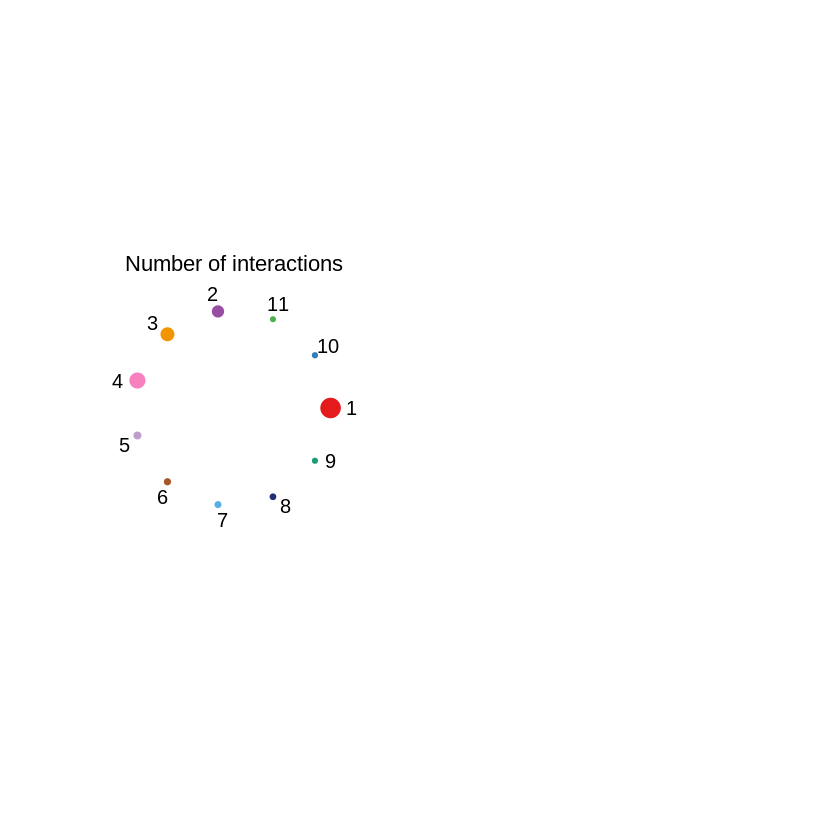

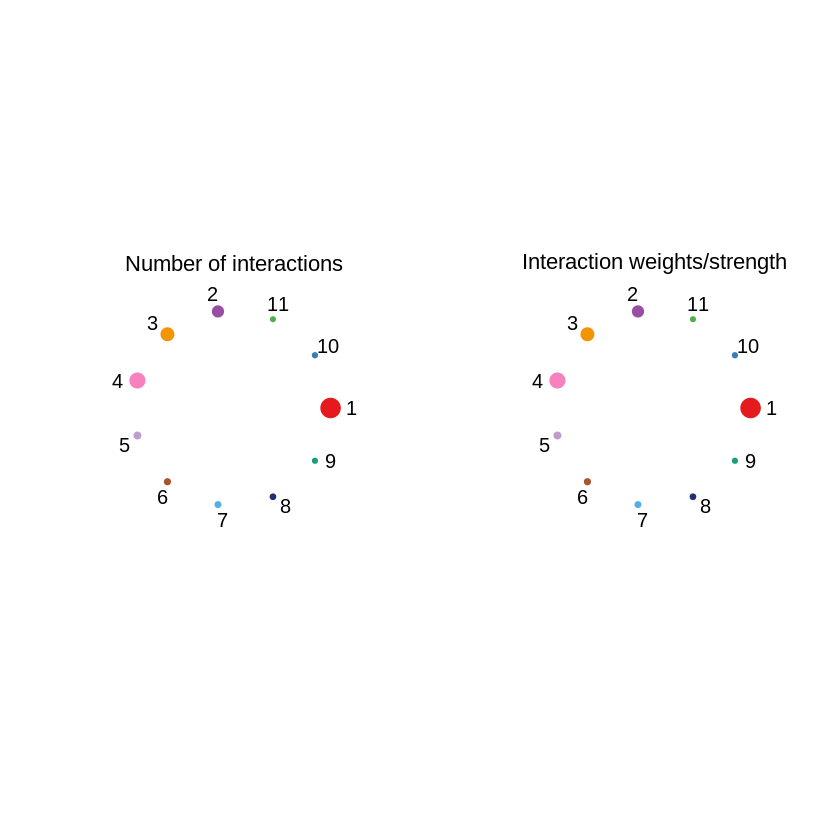

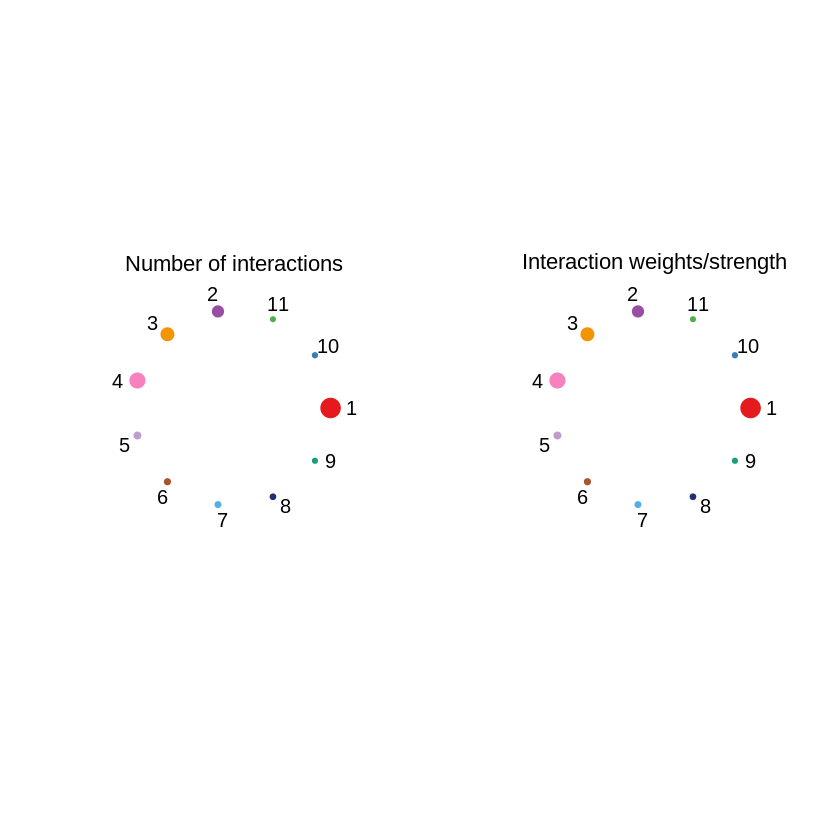

In [54]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

In [24]:
#pdf(file='ground truth interaction by celltype.pdf')
mat <- cellchat@net$weight
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
#dev.off()

ERROR: Error in netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, : object 'groupSize' not found


In [55]:
cellchat@netP$pathways

character(0)

In [29]:
#pdf(file='ground truth MHC-II.pdf')
pathways.show <- c("COLLAGEN") 
vertex.receiver = seq(1,4) # a numeric vector. 
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)

par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
#dev.off()

Cannot find  COLLAGEN . Please input a correct name! 


ERROR: Error in ...future.FUN(...future.X_jj, ...): 


In [56]:
pathways.show <- c("COLLAGEN") 
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(1,4) # a numeric vector. 
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# Circle plot
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")

Cannot find  COLLAGEN . Please input a correct name! 


ERROR: Error in ...future.FUN(...future.X_jj, ...): 


In [31]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

ERROR: Error in net[, , x]: subscript out of bounds


In [28]:
#netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 16, height = 5, font.size = 10)

In [29]:
#pdf("ground truth MHC-II heatmap.pdf") 
#netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 16, height = 5, font.size = 10)
#dev.off()

In [30]:
#pdf("ground truth MHC-II heatmap.pdf") 
#netAnalysis_signalingRole_network(cellchat, width = 16, height = 5, font.size = 10)
#dev.off()

In [31]:
#nPatterns = 4
#cellchat <- identifyCommunicationPatterns(cellchat, pattern = "incoming", k = nPatterns)

In [32]:
#ht1 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing")

In [33]:
#ht1

In [34]:
#ht2 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming")

In [35]:
#ht2

In [36]:
#pdf('ground truth ligand receptor celltype 1.pdf')
#netVisual_bubble(cellchat, sources.use = 1, targets.use = c(1:18), remove.isolate = FALSE)
#dev.off()

In [37]:
pdf('cellchat/pathwaygt_LymphNode.pdf',width=15, height=8)
netVisual_bubble(cellchat, sources.use = (1:18), targets.use = c(1:18), remove.isolate = FALSE)
dev.off()

Comparing communications on a single object 




png 
  2

In [38]:
#pathway.shpw='APP'

In [39]:
#par(mfrow=c(1,1))
ccp = netVisual_heatmap(cellchat, color.heatmap = "Reds")

Do heatmap based on a single object 




In [40]:
pdf(file='cellchat/CCI-gt-LymphNode.pdf')
netVisual_heatmap(cellchat, color.heatmap = "Reds")
dev.off()

Do heatmap based on a single object 




png 
  2

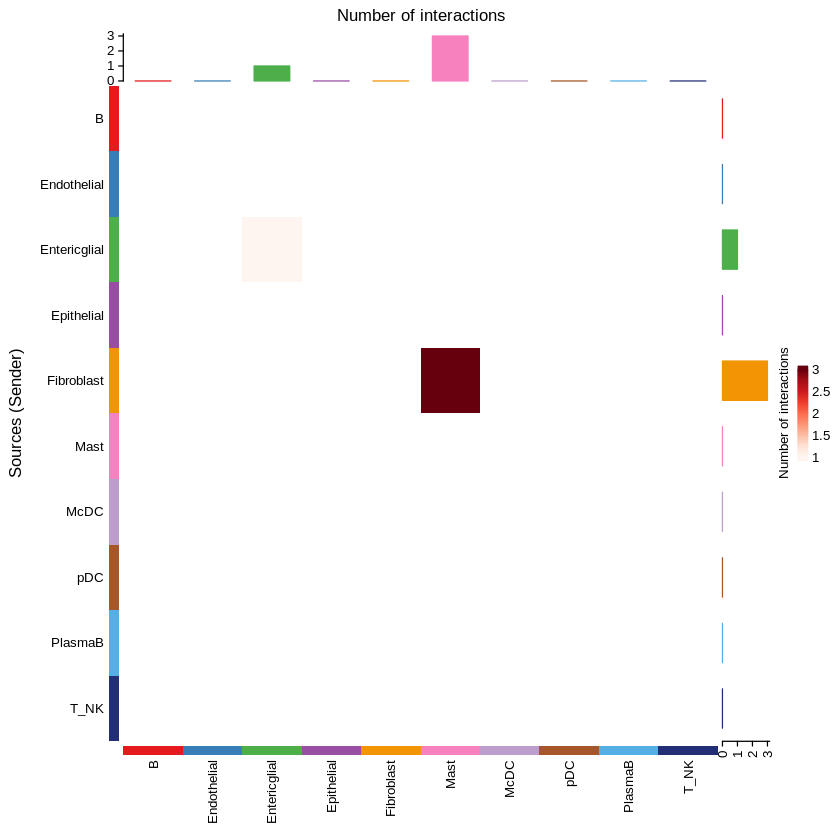

In [41]:
ccp

In [42]:
1+1

[1] 2